# Transformer架构项目实战：基于《Attention is All You Need》论文的Transformer架构实现Grapheme-to-Phoneme（简称G2P，字素到音素）语音合成与识别模型

首先，我们需要先了解什么是G2P语音合成模型：

G2P，即Grapheme-to-Phoneme，是一个关键技术，用于将文字转换为语音。在语音识别和语音合成领域，G2P 起到了核心作用。通过将单词的字母拼写转化为相应的音素形式，计算机得以准确地发音。G2P 的应用广泛，不仅限于自然语言处理和语音合成领域，还对语音识别技术有所贡献。它有助于解决不同语言和方言之间的语音差异问题，并优化了 TTS（文本转语音）和 ASR（自动语音识别）的性能，使其更为准确。

随着人工智能技术的进步，G2P 算法也在不断优化。如今，它已经能够处理不同语言和方言之间的转换，并应对复杂的音素变化和规律。此外，G2P 在自然语言处理的音素归一化等任务中也有所应用，增强了计算机处理复杂语言逻辑的能力。

具体什么意思呢？我们举一个非常简单的例子：

- 现在有一个英文单词mulholland，假如这个单词你之前不认识，那么你现在正在思考的一个问题就是它该怎么发音？

我们能够想到的一个非常好的方法是：将这个单词的音素确定出来，即可按照其音素进行正常的发音：

- mulholland的音素就是：M AH2 L HH AA1 L AH0 N D；

对于计算机来说，也是一样的：

- 计算机需要对一个自然语言进行语音发音，就需要获取该自然语言token所对应的音素序列，只要找到其确定的音素序列，计算机即可根据其音素序列进行准确发音；

所以，G2P语音合成任务的本质就是：

- 构建一个模型，模型对于输入的自然语言序列可以输出其音素序列；

所以该任务本质上仍然是一个Seq2Seq模型；

任务的基本概念理解后，接下来我们开始基于Transformer架构实现一个G2P语音合成模型；首先需要解决的是数据集，这里直接为大家提供一个Kaggle上开源的英文词典数据集之上已完成数据预处理的样本子集，包含训练集、测试集与验证集，**请大家直接从OBS桶上传数据集至notebook环境即可**；


对于每一个样本子集，我们将数据处理为json格式字符串，并持久化为一个json文件，方便模型在训练时高效加载数据，其中每一个json对象映射为Python中的一个dict，key就是原始自然语言token，value就是该token对应的音素序列；

数据的基本信息明确后，接下来我们先实现对给定样本集数据的一些基本处理操作；首先我们先规定好所有的字素及音素集合：

In [2]:
# 准备完整的字素序列，其包含pad（补齐、填充） token、start token、end token以及26个英文小写字母；一般来说，pad token位于序列的第一元素位，即其位于序列中索引为0的位置；
graphemes = ["<pad>", "<s>", "</s>"] + list("abcdefghijklmnopqrstuvwxyz")
# e.g. barranzi -> <s> b a r r a n z i </s>

# 同样，准备完整的音素序列，其包含pad（补齐、填充） token、start token、end token以及26个英文小写字母的音素；音素总计69个
phonemes = ["<pad>", "<s>", "</s>"] + ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0',
                'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2', 'B', 'CH', 'D', 'DH',
                'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2', 'F', 'G', 'HH',
                'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW0', 'OW1',
                'OW2', 'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH0', 'UH1', 'UH2',
                                       'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH']

# 需要对字素序列做标签编码，即id2char；这里的enumerate是枚举函数，可获取graphemes序列的每一个元素对象及其索引，再使用字典的dict对象即可直接构造一个id2char的映射字典
graphemes_id2char = dict(enumerate(graphemes)) # {0:'<pad>', 25: 'k'...}

# 对音素序列同样做标签编码，即id2char；
phonemes_id2char = dict(enumerate(phonemes)) # {0:'<pad>', 23: 'JH', 24:'AH1'}

# 标签编码后的字素序列及音素序列同样也需要char2id
graphemes_char2id = dict((v, k) for k, v in enumerate(graphemes))
phonemes_char2id = dict((v, k) for k, v in enumerate(phonemes))

# 工具函数1：单词 -> id
def word2id(word):
  '''
  给定单词word，转换其为id序列
  e.g. 'jack' -> [1, 13,24,...2]
  '''

  return [graphemes_char2id[c] for c in list(word)]

def id2word(idx_list):
  '''
  给定id序列，转换其为单词
  e.g. [1, 13,24,...2] -> "jack"
  '''
  return ''.join([graphemes_id2char[idx] for idx in idx_list])

def phoneme2id(phoneme_seq):
  '''
  给定音素序列，转换为音素id序列
  e.g. 'JH AE1 K' -> [2, 35, 28]
  '''
  return [phonemes_char2id[p] for p in phoneme_seq.split(' ')]


def id2phoneme(idx_list):
  '''
  给定音素id序列，转换为音素序列
  e.g. [1, 13,24,...2] -> 'JH AE1 K'
  '''
  return ' '.join([phonemes_id2char[idx] for idx in idx_list])

编写完毕后，我们简单测试一下上述工具函数是否可以正确使用：

In [3]:
word = 'jack'
phone_seq = 'JH AE1 K'
print(word2id(word))
print(phoneme2id(phone_seq))

# inverse
print(id2word(word2id(word)))
print(id2phoneme(phoneme2id(phone_seq)))

[12, 3, 5, 13]
[43, 7, 44]
jack
JH AE1 K


确认正确后，接下来我们配置模型的全局超参数：

In [4]:
# 配置全局参数
class Hyperparameters(object):
    # data相关参数
    device = 'cuda' # cuda training, inference cpu

    # 数据的根目录
    data_dir = './data/'

    # 样本子集的加载路径
    train_dataset_path = './data/data_train.json'
    val_dataset_path = './data/data_val.json'
    test_dataset_path = './data/data_test.json'

    # 全局随机种子
    seed = 123

    # 模型相关参数

    # encoder
    encoder_layer = 6 # encoder layer number, default 6 layers

    # encoder块中的hidden layer的dim维度；这里为了方便计算和训练，直接保持token embedding的dim、Transformer hidden的dim，decoder的dim以及位置编码positional encode的dim一致即可
    # 这个维度，在attention is all you need论文中规定的是512，但其实没必要，缩小一些也可以，所以这里就改成了128
    encoder_dim = 128 # token embedding and transformer hidden dimension, decoder dim, positional encode

    # dropout正则化系数
    encoder_drop_prob = 0.1

    # 字素序列的长度
    grapheme_size = len(graphemes_char2id)

    # encode的输入的最大长度
    encoder_max_input = 30

    # 多头自注意力的注意力头的个数
    nhead = 4 # self attention head number，实则几个都行

    # feed-forward layer的dim维度
    encoder_feed_forward_dim = 1024
    decoder_feed_forward_dim = 1024

    # feed-forward layer中加入的dropout正则化系数
    feed_forward_drop_prob = 0.3

    # decoder

    # decoder的层数
    decoder_layer = 6

    # decoder hidden layer的维度，保持与encoder的dim维度一致即可
    decoder_dim = encoder_dim

    # decoder中加入的dropout正则化系数
    decoder_drop_prob = 0.1

    # 音素序列的长度
    phoneme_size = len(phonemes_char2id)

    # 解码的最大步数
    MAX_DECODE_STEP = 50

    # encoder的起始、结束、填充token
    ENCODER_SOS_IDX = graphemes_char2id['<s>']
    ENCODER_EOS_IDX = graphemes_char2id['</s>']
    ENCODER_PAD_IDX = graphemes_char2id['<pad>']

    # decoder的起始、结束、填充token
    DECODER_SOS_IDX = phonemes_char2id['<s>']
    DECODER_EOS_IDX = phonemes_char2id['</s>']
    DECODER_PAD_IDX = phonemes_char2id['<pad>']

    # 训练相关参数

    # 一个batch的样本数量
    batch_size = 128

    # 初始化的学习率
    init_lr = 1e-4

    # 总训练轮数
    epochs = 100

    # 日志记录步数
    verbose_step = 100

    # 模型保存步数
    save_step = 500

    # 梯度grad值的约束，最大为1
    grad_clip_thresh = 1.


HP = Hyperparameters()

然后我们编写dataloader数据集加载对象，完成数据按batch的加载：

In [5]:
from torch.utils.data import Dataset
import json
import torch

# 创建自定义dataloader对象
class G2PDataset(Dataset):
    def __init__(self, dataset_path): # json path

        # json对象从json文件中加载一个样本子集，转换为python的dict对象
        data_dict = json.load(open(dataset_path, 'r'))

        # 字典的item方法可同时获取key和value，用一个元组封装为key-value对，然后返回
        self.data_pairs = list(data_dict.items()) # [('jack', "JH AE1 K"), (...)]

    def __len__(self):

        # 获取样本总数
        return len(self.data_pairs)

    def __getitem__(self, idx):

        # 获取指定某索引位的样本对的单词及其音素序列
        word, phone_seq = self.data_pairs[idx][0], self.data_pairs[idx][1]

        # 转换为id返回
        return word2id(word), phoneme2id(phone_seq) # to idxs ([23,5, 21], [30,54,12])

# dataloader封装时的隐式回调函数
def collate_fn(iter_batch): # pad & descending sort & to tensor：补齐（填充）、降序排列后转换为tensor张量对象

    # 获取一个batch下的样本总数，即batch_size的值
    N = len(iter_batch) # batch size

    # *号拆解iter_batch序列，zip枚举后转换为list返回，同时获取单词的id序列以及音素id序列
    word_indexes, phoneme_indexes = [list(it) for it in zip(*iter_batch)]

    # 这里要做的就是为所有的单词和音素序列添加起始和结束token
    # add start & end token for both word and phoneme
    # input start token
    [it.insert(0, graphemes_char2id['<s>']) for it in word_indexes] # [12, 26, 29]
    [it.append(graphemes_char2id['</s>']) for it in word_indexes]   # [1, 12, 26, 29, 2]

    # MUST! output start and end token
    [it.insert(0, phonemes_char2id['<s>']) for it in phoneme_indexes]  # [12, 26, 29]
    [it.append(phonemes_char2id['</s>']) for it in phoneme_indexes]  # [1, 12, 26, 29, 2]

    # 降序排序
    # descending sort input sequence: [19,18,5...], [1, 0, 2,...]
    word_lengths, sort_idx = torch.sort(torch.tensor([len(it) for it in word_indexes]).long(), descending=True)

    # 获取word的最大长度
    max_word_len = word_lengths[0]

    # padded填充后的word，按所需形状构造一个0矩阵，并返回
    word_padded = torch.zeros((N, max_word_len)).long() # shape: [N, max_seq_len]

    # 获取音素序列的最大长度
    max_phoneme_len = max([len(it) for it in phoneme_indexes])
    phoneme_padded = torch.zeros((N, max_phoneme_len)).long()
    phoneme_lengths = torch.zeros((N,)).long()

    # 这里就是统一转为tensor张量对象
    for idx, idx_s in enumerate(sort_idx.tolist()):
        word_padded[idx][:word_lengths[idx]] = torch.tensor(word_indexes[idx_s]).long()
        phoneme_padded[idx][:len(phoneme_indexes[idx_s])] = torch.tensor(phoneme_indexes[idx_s]).long()
        phoneme_lengths[idx] = len(phoneme_indexes[idx_s])

    # 最终，隐式回调函数对每一个传入的batch加工完毕，返回四个所需的数据对象，这就是后续的输入数据，可供模型训练及推理使用
    return word_padded, word_lengths, phoneme_padded, phoneme_lengths

/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


测试一下自定义dataloader对象，确保没有问题：

In [6]:
from torch.utils.data import DataLoader
val_set = G2PDataset('./data/data_val.json')
val_loader = DataLoader(val_set, batch_size=7, collate_fn=collate_fn)
for batch in val_loader:
    words_idx, words_len, phoneme_seq_idx, phoneme_len = batch
    print('grapheme batch tensor size', words_idx.size())
    print(words_idx)
    print('grapheme lengths: ', words_len)
    print('*'*88)
    print('phoneme batch tensor size', phoneme_seq_idx.size())
    print(phoneme_seq_idx)
    print('phoneme lengths: ', phoneme_len)
    break

grapheme batch tensor size torch.Size([7, 13])
tensor([[ 1, 10,  3,  9,  7, 16, 14, 17,  5, 13,  7, 20,  2],
        [ 1, 15, 23, 14, 10, 17, 14, 14,  3, 16,  6,  2,  0],
        [ 1, 15, 17, 16, 22,  7, 21, 11, 16, 17,  2,  0,  0],
        [ 1,  8, 11, 21, 21, 11, 17, 16,  2,  0,  0,  0,  0],
        [ 1,  4, 11,  3, 26, 11,  3, 14,  2,  0,  0,  0,  0],
        [ 1, 25, 17, 17, 21, 14,  7, 27,  2,  0,  0,  0,  0],
        [ 1, 15,  3, 21, 22, 11, 16,  2,  0,  0,  0,  0,  0]])
grapheme lengths:  tensor([13, 12, 11,  9,  9,  9,  8])
****************************************************************************************
phoneme batch tensor size torch.Size([7, 11])
tensor([[ 1, 36, 32, 35,  9, 47, 45,  5, 44, 28,  2],
        [ 1, 46, 11, 45, 36,  4, 45,  9, 47, 23,  2],
        [ 1, 46, 49, 47, 59, 25, 57, 41, 47, 49,  2],
        [ 1, 34, 38, 58,  9, 47,  2,  0,  0,  0,  0],
        [ 1, 21, 18,  7, 44, 57, 40,  9, 45,  2,  0],
        [ 1, 68, 65, 70, 45, 40,  2,  0,  0,  0,  0],
   

OK，至此前期准备工作完毕，接下来就是最核心的，实现Transformer模型结构；当然，在开始之前，我们再次阅读Transformer架构的图示：

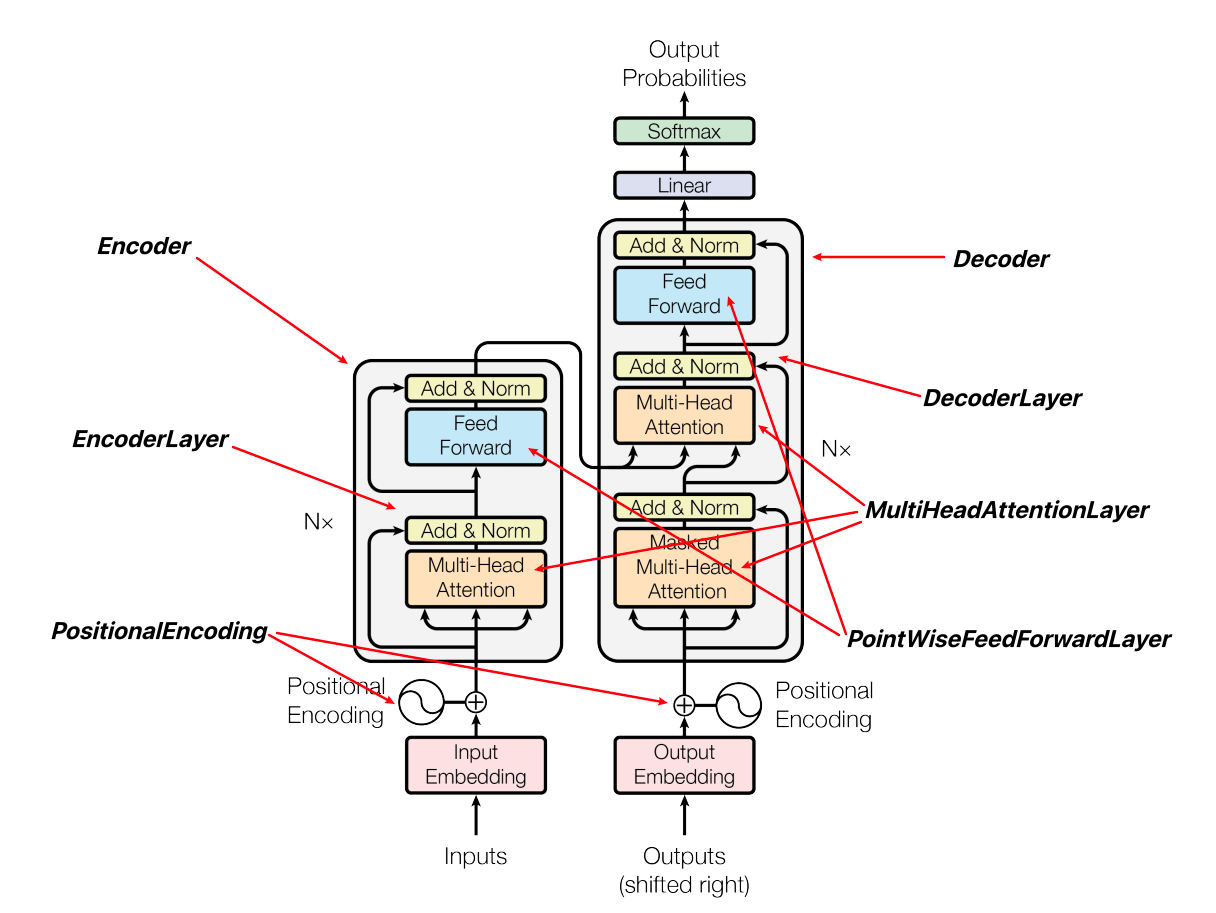

虽然官方论文给出的图示结构看上去较为复杂，但是只要我们选择合理的模型构建思路，也可以按照低耦合的代码形式方便的构建出完整的Transformer网络架构；具体来说就是：

- 封装PositionalEncoding类：单独实现位置编码；
- 封装EncoderLayer类：单独实现Encoder块中的各个Encoder层；
- 封装MultiHeadAttentionLayer类：实现Encoder、Decoder中所需的多头注意力、多头自注意力层；
- 封装PointWiseFeedForwardLayer类：实现FeedForward层；
- 封装Encoder类：基于EncoderLayer、MultiHeadAttentionLayer、PointWiseFeedForwardLayer封装整个Encoder块；
- 封装DecoderLayer类：单独实现Decoder块中的各个Decoder层；
- 封装Decoder类：基于DecoderLayer、MultiHeadAttentionLayer、PointWiseFeedForwardLayer封装整个Decoder块；
- 封装Transformer类：基于构建好的Encoder、Decoder块最终实现整个Transformer网络架构；

接下来我们就一个一个类开始封装，我们先实现PositionalEncoding位置编码；

前序理论学习部分中我们已经知道：

- Transformer中使用某种公式来直接计算位置编码：

$$
PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}}) \\
PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}}) 
$$

其中：

- $2i$表示偶数位置；
- $2i+1$表示奇数位置；
- $pos$就是位置映射值[0,1,2,...]；
- $d_{model}$就是token embedding的维度；原论文中是512，这里我们以本案例中规定的维度为准即可；
- $2i$或 $2i+1$就表示 $d_{model}$维数中的偶数位或奇数位；

上述公式也就是说：

- 偶数位置的位置编码使用 $PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}})$来计算；
- 奇数位置的位置编码使用 $PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})$来计算；

例如：

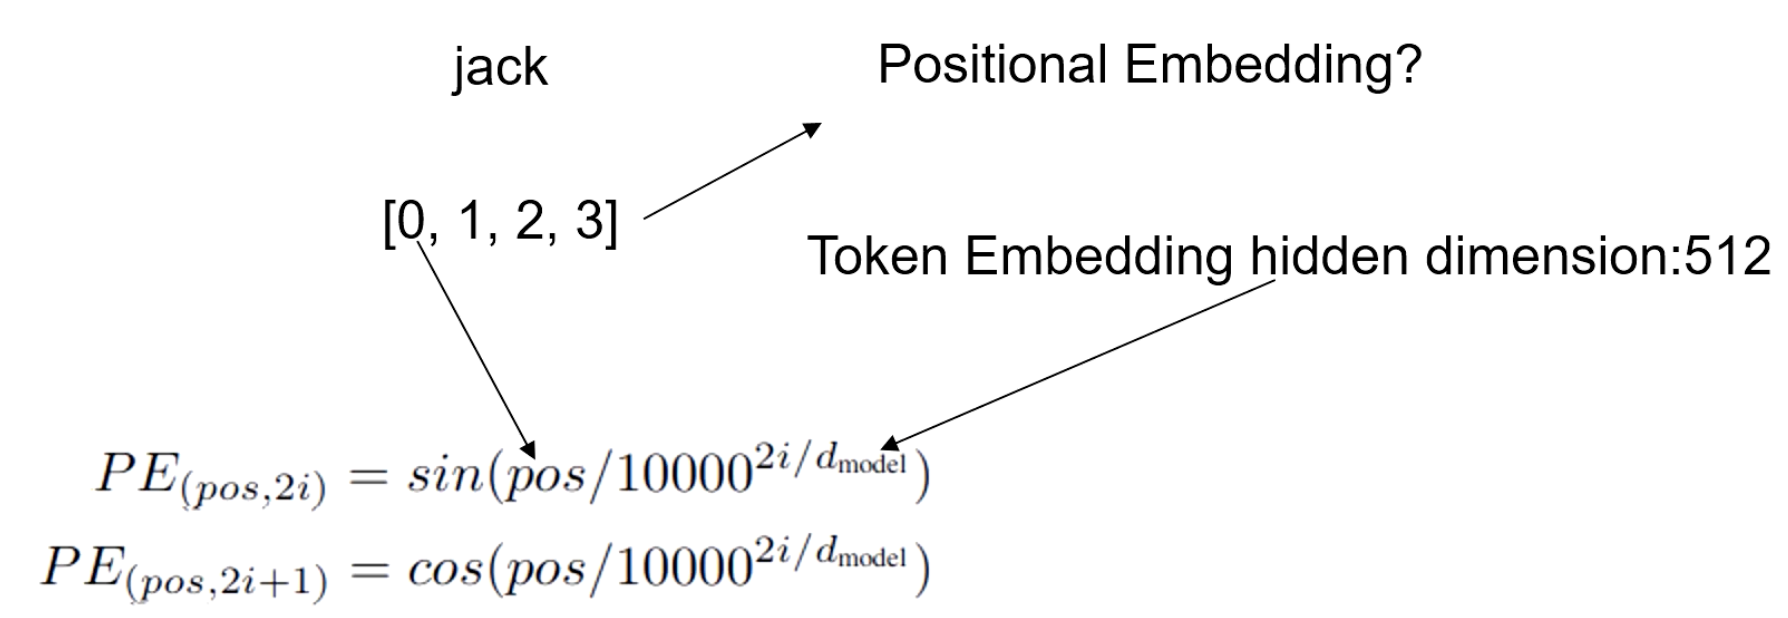

所以这里给定的计算量都是固定的，并没有额外引入其他参数，即没有需要优化的参数，所以PositionalEncoding并不是一个需要实现的网络层，这里仅仅只是在实现位置编码的计算；

明白位置编码的计算原理后，接下来我们只需要通过程序来实现这个计算过程即可：

In [8]:
import torch
from torch import nn
from config import HP
import torch.nn.functional as F
import math

# 创建PositionalEncoding类，先实现位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000,):
        '''
        d_model:token embedding的维度；
        max_len:输入的最大的长度，这里保持与公式中的10000一致即可
        '''
        super(PositionalEncoding, self).__init__()

        # torch.arange方法是生成一个一维张量tensor，给定序列的起始值、结束值及其步长；这里的步长为2，统一以偶数位为步长，奇数位即2i+1
        # .float()方法是将张量中的值统一转换成float类型
        # 这里相当于是e的{2i * 1/d_model * ln10000}次方=e的{ln10000的2i * 1/d_model次方}次方=1000的2i * 1/d_model次方
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-math.log(10000.)/d_model))

        # 这里就是准备pos
        position = torch.arange(max_len).unsqueeze(1)

        # 初始化pe向量
        pe = torch.zeros(1, max_len, d_model)

        # 偶数位计算pe位置编码值
        pe[0, :, 0::2] = torch.sin(position * div_term)

        # 奇数位计算pe位置编码值
        pe[0, :, 1::2] = torch.cos(position * div_term)

        # 注册全局变量
        self.register_buffer('pe', pe)

    def forward(self, x):

        # input的embedding和pe拼接即可，然后返回
        x = x + self.pe[:, :x.size(1), :]
        return x

位置编码实现后，为了最终能够实现Encoder、Decoder以及整个Transformer架构，接下来我们需要梳理正确的网络结构实现思路：

- 按照前序介绍，一个Encoder或Decoder块中不仅需要实现EncoderLayer，还需要实现MultiHeadAttentionLayer、PointWiseFeedForwardLayer；

所以接下来正确的模型结构实现顺序是：

- 先实现MultiHeadAttentionLayer及PointWiseFeedForwardLayer；
- 再基于此实现EncoderLayer和DecoderLayer；
- 然后再实现Encoder和Decoder块；
- 最终实现完整Transformer网络结构；

思路梳理清楚，继续一个一个实现，先实现MultiHeadAttentionLayer，即下述Transformer架构图示中红框所示的这部分：

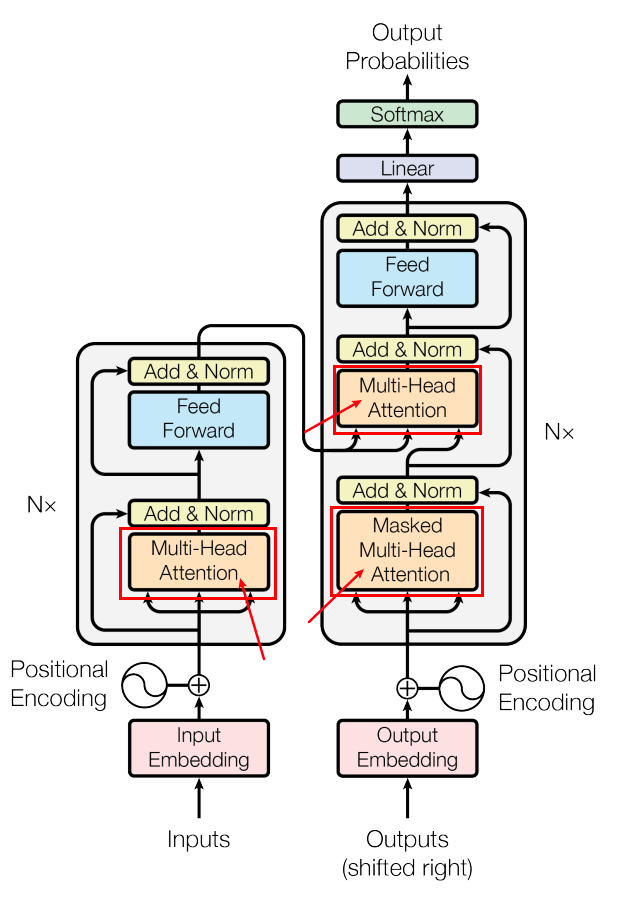

当然，其实从代码实现层面来看，这三部分的多头注意力层其实是共用同一个MultiHeadAttentionLayer对象的，所以MultiHeadAttentionLayer类只需实现一个对象即可；

In [9]:
class MultiHeadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, nhead):
        '''
        :params hid_dim:encoder或decoder的维度；
        :params nhead:多头注意力的注意力头数
        '''
        super(MultiHeadAttentionLayer, self).__init__()
        
        # 指定encoder或decoder的维度
        self.hid_dim = hid_dim  # 128
        
        # 指定注意力头的数量
        # 但是注意：这里头数虽然任意，但要求hid_dim能够被nhead整除，否则无法分出整数个头
        self.nhead = nhead  # e.g. 如果隐藏层的维度是128，则头数只能给为偶数，比如2, 4, 8都行，但如果是9就不行，因为除不尽了。
        
        # 所以这里要加一个断言，只有除尽了，能分出整数个头，才能进行后续的多头注意力计算，否则就直接报错。
        assert not self.hid_dim % self.nhead
        
        # 然后结合隐藏层的维度及注意力头数量，计算得出每一个注意力头的输入维度
        self.head_dim = self.hid_dim // self.nhead

到这我们先不着急继续往下写，我们还是先回到原论文，看下这里到底要做一些什么样的注意力计算；我们需要进入到论文3.2小节来精读一下：

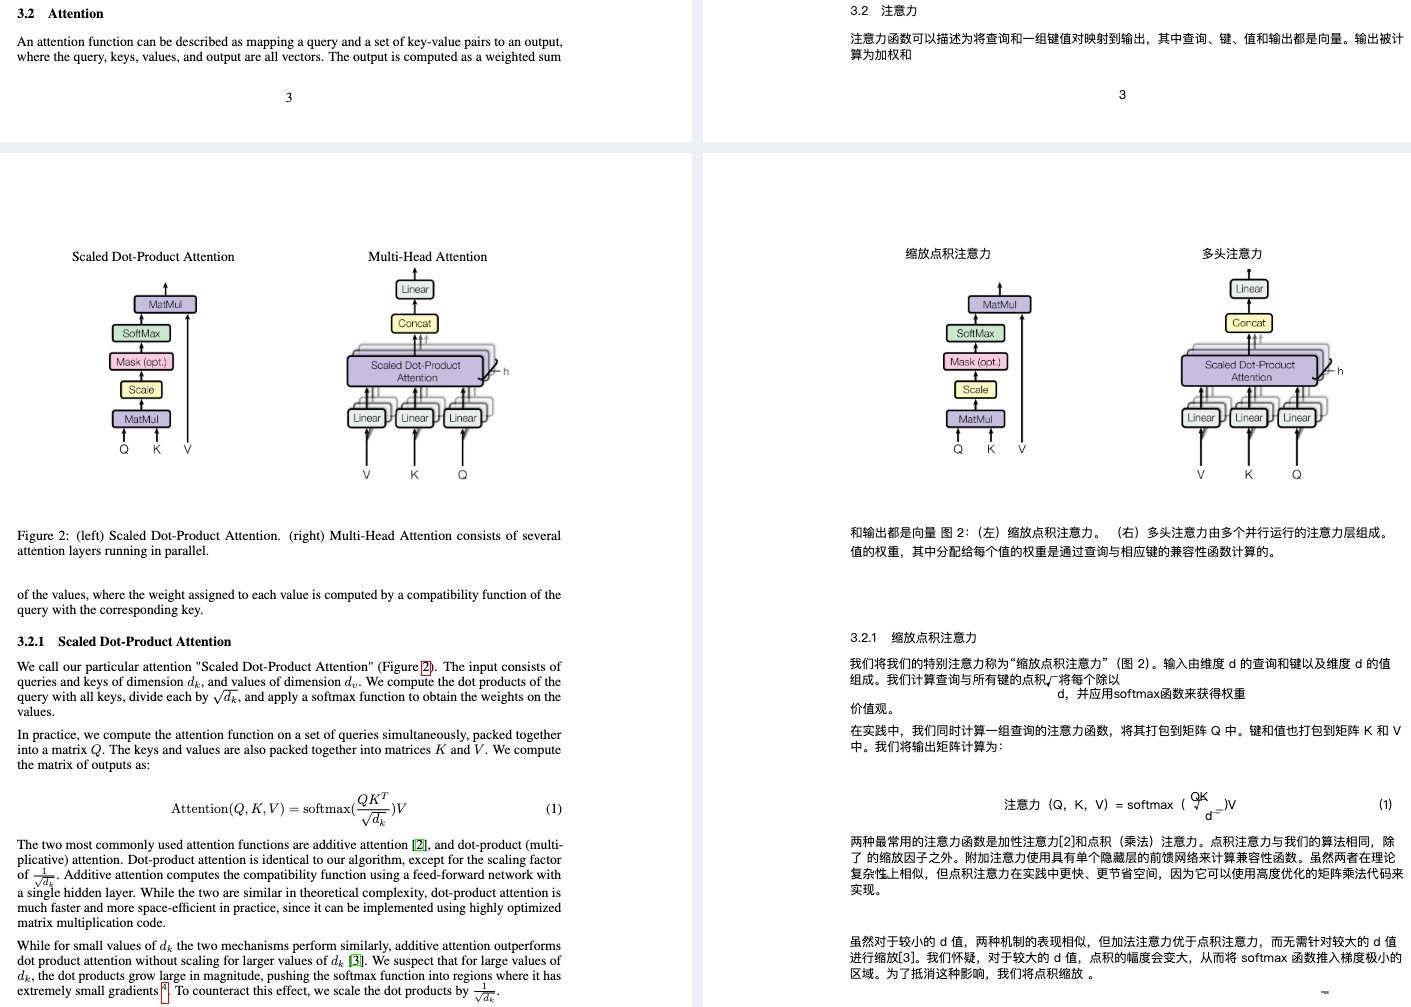

原论文这里，提到了一种名叫Scaled DotProduct Attention的注意力机制：
- Scaled Dot-Product Attention是一种特殊的attention，输入包括查询Q和键K的维度$d_k$ 以及值V的维度$d_v$ ;

计算查询和键的点积，将每个结果除以$\sqrt{d_k}$，然后用softmax() 函数来获得值的权重；

在实际使用中，我们同时计算一组查询的注意力函数，并一起打包成矩阵 Q，键和值也一起打包成矩阵 K 和 V；

啥意思呢？这里其实就是前面所讲过的自注意力机制，其Attention 权重的计算方式就是：

$$
Attention(Q,K,V)=softmax(\frac {Q*K^T}{\sqrt{d_k}})*V=Z
$$

这里也额外再次说明下：
- 为什么用softmax：对于一个Q会给n个K-V对，Q会和每个K-V对做内积，产生n个相似度。传入softmax后会得到n个非负并且和为1的权重值，把权重值与V矩阵相乘后得到注意力的输出；
- 为什么除以$\sqrt{d_k}$：虽然对于较小的$d_k$两者的表现相似，但在较大的$d_k$时，加法注意力要优于没有缩放机制的点积注意力；我们认为在较大的$d_k$时，点积以数量级增长，将 softmax 函数推入梯度极小的区域，值就会更加向两端靠拢，算梯度的时候，梯度就比较小；为了抵抗这种影响，我们使用$\displaystyle \frac {1}{\sqrt{d_k}}$缩放点积结果；

具体的，原论文中用下述图示简易的描述了缩放点积注意力的计算过程：

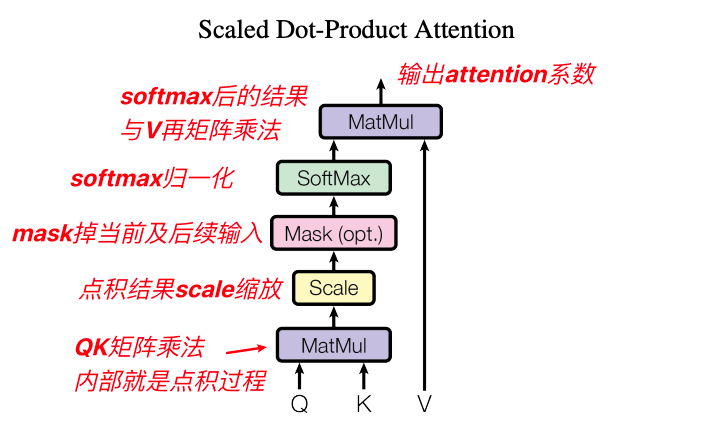

当然，前序我们单独讲解的自注意力机制的运算过程图示会更加详细，这里就不再做过多赘述；

然后，基于单个的缩放点积注意力计算过程，在此基础上Transformer引入多头注意力，即通过`nhead`参数指定`nhead`个注意力头，在单个注意力头上就是一次完整的缩放点积注意力运算过程：
- Q、K、V分别通过一个`Linear`来封装；
- Q、K、V进行一次完整的缩放点积注意力运算；
- `nhead`个头上的缩放点积注意力运算结果concat拼接；
- 再经过一个output的Linear进行输出即可；

具体的如图所示：

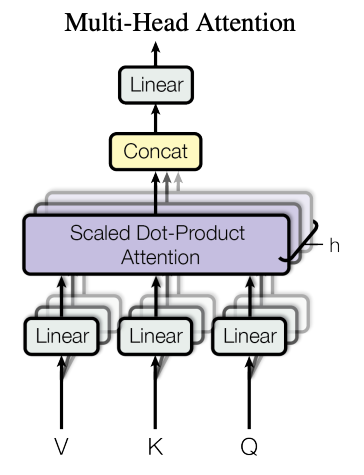

这里，与之前理论讲解部分中提及的多头注意力机制运算过程一致；

当然，还有一个细节，大家需要注意，我们还是重点观察Transformer架构图示中的这三个多头注意力层：

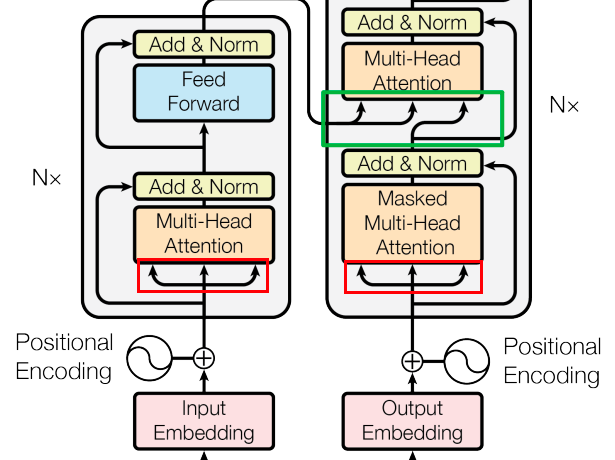

注意我用不同的绿色框框出来的这个多头注意力层：
- Encoder的多头注意力层和Decoder中Masked多头注意力层采用的是多头自注意力，从红框图示中所示的三个箭头可以发现：Q、K、V实则来自同一输入；
- 但Decoder的第二个多头自注意力层中，Q、K和V并不是来自同一输入，其中Q、K来自Encoder的输出，所以这个多头注意力层不是多头自注意力；

OK，至此我们依托原始论文清楚的明确了Transformer架构中Encoder与Decoder中涉及的多头注意力运算过程及其注意力层的实现步骤，接下来可以继续往下编写代码了：


In [10]:
class MultiHeadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, nhead):
        '''
        :params hid_dim:encoder或decoder的维度；
        :params nhead:多头注意力的注意力头数
        '''
        super(MultiHeadAttentionLayer, self).__init__()
        
        # 指定encoder或decoder的维度
        self.hid_dim = hid_dim  # 128
        
        # 指定注意力头的数量
        # 但是注意：这里头数虽然任意，但要求hid_dim能够被nhead整除，否则无法分出整数个头
        self.nhead = nhead  # e.g. 如果隐藏层的维度是128，则头数只能给为偶数，比如2, 4, 8都行，但如果是9就不行，因为除不尽了。
        
        # 所以这里要加一个断言，只有除尽了，能分出整数个头，才能进行后续的多头注意力计算，否则就直接报错。
        assert not self.hid_dim % self.nhead
        
        # 然后结合隐藏层的维度及注意力头数量，计算得出每一个注意力头的输入维度
        self.head_dim = self.hid_dim // self.nhead
        
        # ====继续多头注意力运算的实现过程====
        
        # 按原始论文图示，Q、K、V用三个相同的Linear来封装
        self.fc_q = nn.Linear(self.hid_dim, self.hid_dim)
        self.fc_k = nn.Linear(self.hid_dim, self.hid_dim)
        self.fc_v = nn.Linear(self.hid_dim, self.hid_dim)
        
        # 还需定义output的Linear
        self.fc_o = nn.Linear(self.hid_dim, self.hid_dim)
        
        # 缩放因子的声明，注册为scale全局变量，方便直接使用
        self.register_buffer('scale', torch.sqrt(torch.tensor(self.hid_dim).float()))

    # query: # [N, max_seq_len_q, en_dim]
    # key:   # [N, max_seq_len_k, en_dim]
    # value: # [N, max_seq_len_v, en_dim]
    def forward(self, query, key, value, inputs_mask=None):
        '''
        多头注意力的forward过程
        :params query:查询向量
        :params key:键向量
        :params value:值向量
        :params inputs_mask:可选是否mask掉目标输入信息，这里就是为了masked多头注意力来准备的，因为我们希望用一个多头注意力对象适配所有的多头注意力层
        '''
        
        # 获取batch_size大小
        bn = query.size(0)
        
        # 生成Q、K、V
        Q = self.fc_q(query)    # [N, max_seq_len_q, en_dim]
        K = self.fc_k(key)      # [N, max_seq_len_k, en_dim]
        V = self.fc_v(value)    # [N, max_seq_len_v, en_dim]
        
        # 开始划分多头，原本是3维的tensor，转置为4维的
        # split into nhead: 128 hid_dim, 4 heads, -> head_dim = 128/4=32
        # 各维度的含义：[N, nhead, max_seq_len_q, head_dim]
        Q = Q.view(bn, -1, self.nhead, self.head_dim).permute((0, 2, 1, 3))
        
        # [N, nhead, max_seq_len_k, head_dim]
        K = K.view(bn, -1, self.nhead, self.head_dim).permute((0, 2, 1, 3))
        
        # [N, nhead, max_seq_len_v, head_dim]
        V = V.view(bn, -1, self.nhead, self.head_dim).permute((0, 2, 1, 3))

        # Energy calc
        # Q: [N, nhead, max_seq_len_q, head_dim]
        # K^T: [N, nhead, head_dim, max_seq_len_k]
        # energy: [N, nhead, max_seq_len_q, max_seq_len_k]
        # 这里就是在计算QK^T/sqrt{d_k}
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        # 特殊情况判断一下：如果inputs_mask不为空，就是需要有mask的输入
        if inputs_mask is not None:
            """
            [[True, True, 7, 12, 2],
             [1, 3, 5, 2, False]
             [1, 3, 2, False, False]
             ....
            ]
            """
            
            # 那就mask一下
            energy = energy.masked_fill(inputs_mask == 0, -1.e10)
            
        # 这里就是用softmax归一化
        # attention:[N, nhead, max_seq_len_q, max_seq_len_k]
        attention = F.softmax(energy, dim=-1)

        # attention:[N, nhead, max_seq_len_q, max_seq_len_k]
        # V:        [N, nhead, max_seq_len_v, head_dim]
        # max_seq_len_v = max_seq_len_k
        # out:      [N, nhead, max_seq_len_q, head_dim]
        # 这里就是最终执行attention函数，计算attention系数
        out = torch.matmul(attention, V)
        
        # out.permute((0, 2, 1, 3)): [N, max_seq_len_q, nhead, head_dim]
        # 这里是维度变换后拼接起来
        out = out.permute((0, 2, 1, 3)).contiguous() # memory layout
        
        # 然后输出重新转置tensor的形状，回到一开始的形状
        out = out.view((bn, -1, self.hid_dim)) # [N, max_seq_len_q, hid_dim]
        
        # 然后再进入最后的output的fc全连接
        out = self.fc_o(out)
        
        # 最终，返回结果，包括整个attention的输出及其attention系数
        return out, attention  # [N, max_seq_len_q, hid_dim] 'jack' -> "JH AE1 K"

MultiHeadAttentionLayer多头注意力层到此就实现完毕了，我们继续来实现PointWiseFeedForwardLayer层；同样，我们还是先精读一下原始论文关于这部分网络的讲解：

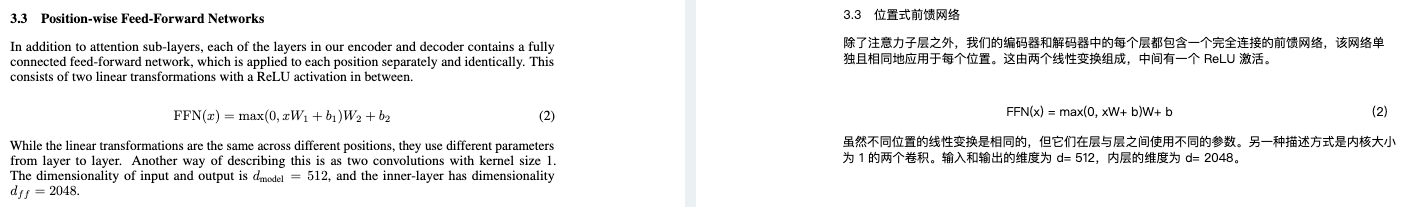

这个Position-wise Feed-Forward Networks是一个基于位置的前馈神经网络，它分别相同地应用于每个位置。它由两个线性变换和中间的一个ReLU激活函数组成，具体的，该网络层的决策函数是：

$$
FFN(x)=max(0,xW_1+b_1)W_2+b_2
$$

两个线性转换作用于相同的位置，但是在他们用的参数不同；
当然，原论文中也给出了另一种描述方式：
- 我们可以将其比作两个knernel size=1的卷积核，输入输出的维度为512，中间维度为2048；

当然，还有一个小细节：
- 在模型的训练过程中，我们引入了一系列的正则化操作，主要是Residual Dropout以及Label Smoothing；

这部分在原文中的5.4小节给出了补充说明：

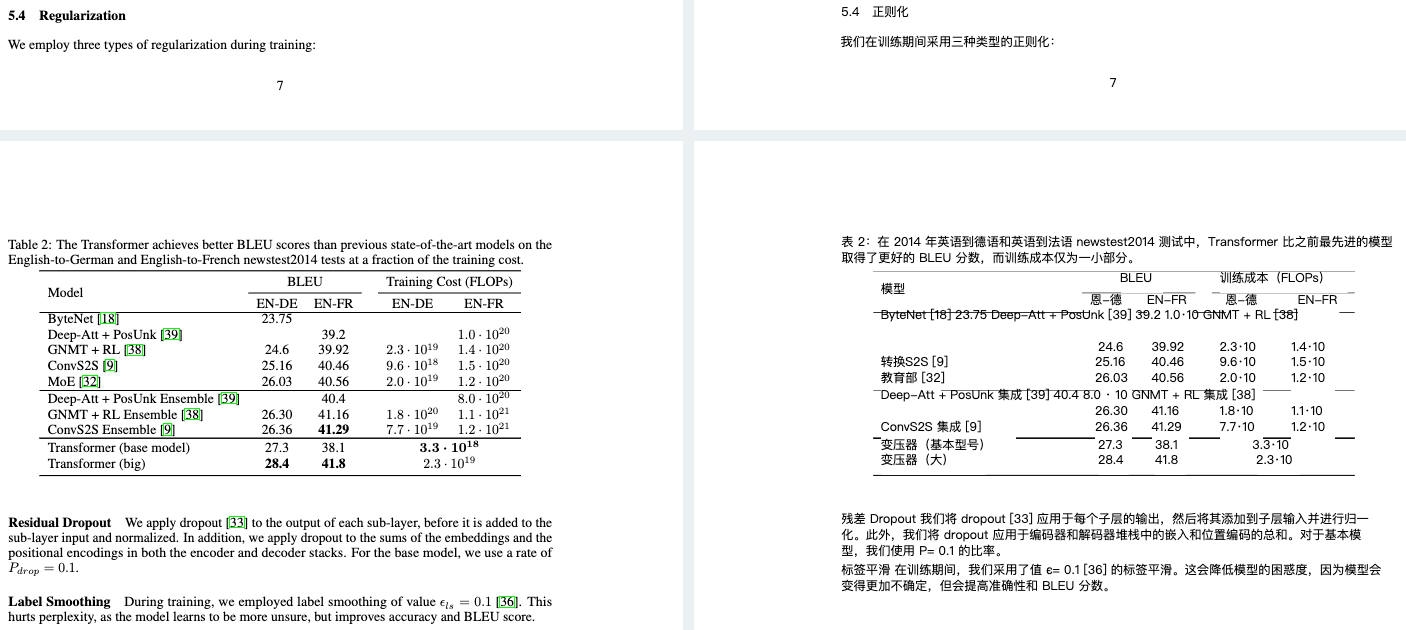

其中：
- Residual Dropout：在additive操作和normalized操作之前执行dropout操作，但凡是带有权重的层，都有dropout=0.1；
- Label Smoothing：使用交叉熵计算损失时，只考虑到训练样本中正确的标签位置的损失，而忽略了错误标签位置的损失；加入Label Smoothing可以有效避免上述错误，训练中使用了0.1的标签平滑，使得模型学到了更多的不确定性；

所以：
- 在接下来构建PointWiseFeedForwardLayer时需要加入dropout正则化操作，需指定其正则化系数；

基本明确后，我们开始编写此网络层的代码：



In [11]:
class PointWiseFeedForwardLayer(nn.Module):
    def __init__(self, hid_dim, pff_dim, pff_drop_out):
        '''
        实现基于位置编码信息的fc全连接前馈神经网络层
        :params hid_dim:隐藏层的维度
        :params pff_dim:PointWiseFeedForwardLayer的维度
        :params pff_drop_out:该层上应用dropout正则化的正则化系数
        注意：这里的dropout正则化的加入在原文5.4小节中已经补充说明
        '''
        super(PointWiseFeedForwardLayer, self).__init__()
        
        # 隐藏层的维度
        self.hid_dim = hid_dim
        
        # PointWiseFeedForwardLayer的维度
        self.pff_dim = pff_dim
        
        # 指定正则化系数
        self.pff_drop_out = pff_drop_out
        
        # 两个fc全连接
        self.fc1 = nn.Linear(self.hid_dim, self.pff_dim)
        self.fc2 = nn.Linear(self.pff_dim, self.hid_dim)
        
        # dropout正则化
        self.dropout = nn.Dropout(self.pff_drop_out)

    def forward(self, inputs):  # inputs: [N, max_seq_len, hid_dim]
        
        # 输入先进fc1，dropout正则化后再进fc2，得到该层最终的输出，直接返回即可
        inputs = self.dropout(F.relu(self.fc1(inputs))) # [N, max_seq_len, pff_dim]
        out = self.fc2(inputs)  # [N, max_seq_len, hid_dim]
        
        return out  # [N, max_seq_len, hid_dim]


至此，整个Transformer架构中的三个基础网络层全部实现完毕，接下来我们开始基于这三个封装完毕的网络层，开始逐步实现Encoder、Decoder块及完整的Transformer结构；我们先实现EncoderLayer层结构：

In [12]:
# 实现EncoderLayer
class EncoderLayer(nn.Module):
    
    def __init__(self):
        super(EncoderLayer, self).__init__()
        
        # 先实现Encoder中多头注意力层之后的LN横向规范层
        self.self_att_layer_norm = nn.LayerNorm(HP.encoder_dim)
        
        # 再实现Encoder中pff(基于位置编码的fc全连接前馈神经网络层)层之后的LN横向规范层
        self.pff_layer_norm = nn.LayerNorm(HP.encoder_dim)
        
        # 基于MultiHeadAttentionLayer对象实现多头自注意力层
        self.self_att = MultiHeadAttentionLayer(HP.encoder_dim, HP.nhead)
        
        # 基于PointWiseFeedForwardLayer对象实现pff层
        self.pff = PointWiseFeedForwardLayer(HP.encoder_dim, HP.encoder_feed_forward_dim, HP.feed_forward_drop_prob)
        
        # 当前EncoderLayer也需要接dropout正则化
        self.dropout = nn.Dropout(HP.encoder_drop_prob)

    def forward(self, inputs, inputs_mask):
        
        # inputs shape: [N, max_seq_len, en_dim]
        # 输入inputs先进多头注意力层，输出_inputs
        _inputs, att_res = self.self_att(inputs, inputs, inputs, inputs_mask) # [N, max_seq_len, en_dim]
        
        # 实现skip connection残差连接，即原输入inputs与dropout正则化后的_inputs拼接，进入Encoder中多头注意力层之后的LN横向规范层，得到输出inputs
        inputs = self.self_att_layer_norm(inputs+self.dropout(_inputs)) # [N, max_seq_len, en_dim]
        
        # inputs继续进Encoder中pff(基于位置编码的fc全连接前馈神经网络层)层之后的LN横向规范层
        _inputs = self.pff(inputs)
        
        # 实现skip connection残差连接，即前序输入inputs与dropout正则化后的_inputs拼接，进入Encoder中pff(基于位置编码的fc全连接前馈神经网络层)层之后的LN横向规范层，得到输出inputs
        inputs = self.pff_layer_norm(inputs + self.dropout(_inputs))
        
        # 此时的inputs即单个EncoderLayer所得的输出，直接返回即可
        return inputs   # [N, max_seq_len, en_dim]


单个EncoderLayer结构实现完毕，整个6层Encoder块即可实现了：

In [13]:
# 实现完整的Encoder块
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # 输入token embedding一下
        self.token_embedding = nn.Embedding(HP.grapheme_size, HP.encoder_dim)
        
        # 准备位置编码层，稍后forward时即得位置编码矩阵
        self.pe = PositionalEncoding(d_model=HP.encoder_dim, max_len=HP.encoder_max_input)
        
        # 按照原论文结构，准备6个EncoderLayer层的完整Encoder结构
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(HP.encoder_layer)])
        
        # 接dropout正则化
        self.drop = nn.Dropout(HP.encoder_drop_prob)
        
        # 注册缩放因子，保存为全局变量
        self.register_buffer('scale', torch.sqrt(torch.tensor(HP.encoder_dim).float()))

    def forward(self, inputs, inputs_mask):
        
        # inputs shape: [N, max_seq_len]
        # 给定输入，完成input embedding
        token_emb = self.token_embedding(inputs) # token(inputs) embedding [N, max_seq_len, en_dim]
        
        # 计算得到位置编码矩阵
        inputs = self.pe(token_emb*self.scale) # positional encoding [N, max_seq_len, en_dim]
        
        # 正则化
        inputs = self.drop(inputs)  # [N, max_seq_len, en_dim]

        # loop encoder layer: 6 layers
        # 6个EncoderLayer，逐层进行forward
        for idx, layer in enumerate(self.layers):
            inputs = layer(inputs, inputs_mask)
        
        # 最终的inputs即Encoder输出的上下文向量c，直接输出即可，稍后会进入Decoder的多头注意力层，作为Q、K的输入
        return inputs # [N, max_seq_len, en_dim]

继续实现DecoderLayer的单层结构：

In [14]:
# 实现DecoderLayer
class DecoderLayer(nn.Module):
    
    def __init__(self):
        
        super(DecoderLayer, self).__init__()
        
        # 准备Masked多头注意力层
        self.mask_self_att = MultiHeadAttentionLayer(HP.decoder_dim, HP.nhead)
        
        # 准备Decoder中Maske多头自注意力层后的LN横向规范层
        self.mask_self_norm = nn.LayerNorm(HP.decoder_dim)
        
        # 准备DecoderLayer中的第二个多头注意力层；注意：该注意力层不是多头自注意力层！
        self.mha = MultiHeadAttentionLayer(HP.decoder_dim, HP.nhead)
        
        # 准备Decoder中第二个多头注意力层后的LN横向规范层
        self.mha_norm = nn.LayerNorm(HP.decoder_dim)
        
        # 基于PointWiseFeedForwardLayer对象准备pff层
        self.pff = PointWiseFeedForwardLayer(HP.decoder_dim, HP.decoder_feed_forward_dim, HP.feed_forward_drop_prob)
        
        # 准备pff层后的LN横向规范层
        self.pff_norm = nn.LayerNorm(HP.decoder_dim)
        
        # 准备dropout正则化
        self.dropout = nn.Dropout(HP.decoder_drop_prob)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # 输入是trg，先进第一个Masked多头自注意力层，得到输出_trg
        _trg, _ = self.mask_self_att(trg, trg, trg, trg_mask) # self attention 不仅要mask padding, 还要保证解码t时刻，只能看到t和t之前的时间步
        
        # 实现skip connection：第一个Masked多头自注意力层的输出_trg经dropout正则化后原输入trg拼接，进入第一个Masked多头自注意力层后的LN横向规范层，得到输出trg
        trg = self.mask_self_norm(trg+self.dropout(_trg))
        
        # trg、Encoder输出的上下文向量以及mask进入Decoder中第二个多头注意力层，得到输出_trg及其attention系数
        _trg, attention = self.mha(trg, enc_src, enc_src, src_mask)
        
        # 实现skip connection：该多头注意力层的输出_trg经dropout正则化后与前序输入trg拼接后进第二个多头注意力层后的LN横向规范层，得到输出trg
        trg = self.mha_norm(trg+self.dropout(_trg))
        
        # trg继续进pff层，得到输出_trg
        _trg = self.pff(trg)
        
        # 实现skip connection：_trg经dropout正则化后与前序输入trg拼接，进入pff层后的LN横向规范层
        trg = self.pff_norm(trg+self.dropout(_trg))
        
        # 此时的输出即单个Decoder层的输出，直接返回即可
        return trg, attention   # attention: plot attention map

然后封装完整的Decoder结构：

In [15]:
# 实现最终完整的Decoder块
class Decoder(nn.Module):
    
    def __init__(self):
        
        super(Decoder, self).__init__()
        
        # output，即音素序列输入，完成token的embedding
        self.token_embedding = nn.Embedding(HP.phoneme_size, HP.decoder_dim)
        
        # 准备位置编码层
        self.pe = PositionalEncoding(d_model=HP.decoder_dim, max_len=HP.MAX_DECODE_STEP)
        
        # 准备6层DecoderLayer的Decoder块
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(HP.decoder_layer)])
        
        # 6层DecoderLayer构成的完整Decoder块之后，还要再接一个fc全连接
        self.fc_out = nn.Linear(HP.decoder_dim, HP.phoneme_size) # in_feature: 128, phoneme_size
        
        # 以及dropout正则化
        self.drop = nn.Dropout(HP.decoder_drop_prob)
        
        # 注册缩放因子，保存为全局变量
        self.register_buffer('scale', torch.sqrt(torch.tensor(HP.decoder_dim).float()))

    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # token先embedding
        token_emb = self.token_embedding(trg)
        
        # 计算得到位置编码矩阵
        pos_emb = self.pe(token_emb*self.scale)
        
        # dropout正则化
        trg = self.drop(pos_emb) # [N, max_seq_len, de_dim]
        
        # Decoder的每一个DecoderLayer逐层开始forward
        for idx, layer in enumerate(self.layers):
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        # 整个Decoder的输出再接最后一个output的fc全连接
        out = self.fc_out(trg)  # [N, seq_len, phoneme_size]
        
        # 至此，Decoder的forward结束，返回结果即可
        return out, attention

至此，Encoder块的完整结构、Decoder块的完整结构均实现完毕，接下来直接基于Encoder、Decoder结构，实现最终完整的Transformer网络结构；

当然，在实现整个Transformer架构之前，对于Encoder输出的上下文向量，Decoder到底是如何解码进行最终结果输出的，包括之前我们提到了的Masked多头自注意力到底是怎样的运算流程，我们还需要再分析一下，如下图所示：


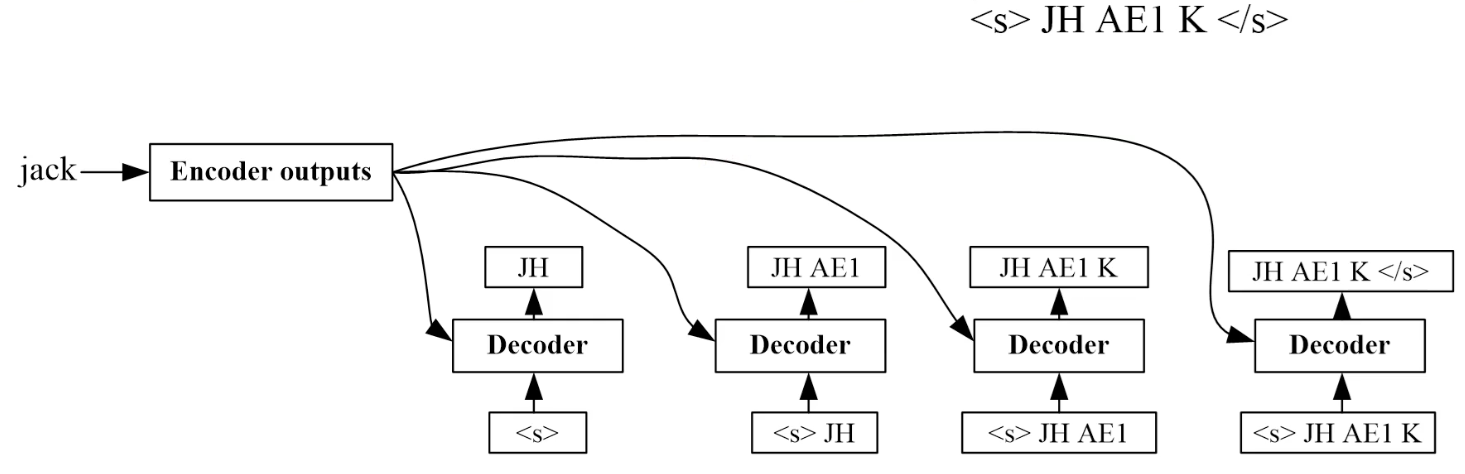

- 比如现在有一个word，叫做jack；
- 在模型做推理的时候，我们需要保障其输出jack这个单词的准确音素序列；

那么具体的解码流程是：
- 第一步，我们先将jack这个word送到Encoder，Encoder会得到一个输出，也就是上下文向量c；
- 第二步，从start token开始，Decoder第一个需要解码得到的输出就是音素`JH`；
- 第三步，将start token和Decoder第一个解码输出的因素`JH`拼接在一起，继续输入到Decoder，让Decoder第二次进行解码，得到的输出就是音素`JH`后的第二个音素，即`AE1`；
- 以此类推，Decoder进行第三次解码，得到因素`AE1`的下一个解码输出，即音素`K`、end token`</s>`；
- 最终，Decoder本轮解码完毕，输出结果完整；

也就是说：
- 在Decoder的每一步解码中，我们希望的Decoder输入是当前step及其之前的信息；
- 每一步解码期望得到的输出就是当前step的下一位的解码信息；

也就是：
- Decoder的每一轮解码需要依靠当前step的左侧信息；
- Decoder的解码结果按解码步向右移一位；
- 直至解码到end token，Decoder的解码也就结束了；

这也是为什么在Transformer架构图示中，Decoder的输入下作者给了一个描述：shifted right的原因；


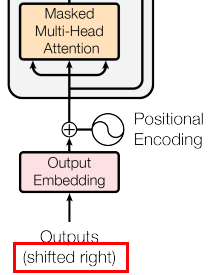

这里明确之后，大家似乎也就明白了：
- 为何要对outputs当前step及其右侧的信息进行Masked操作了；

那么接下来，我们就来实现Transformer架构：







In [18]:
# 实现Transformer整体网络结构
class Transformer(nn.Module):
    
    def __init__(self):
        
        super(Transformer, self).__init__()
        
        # 创建Encoder块
        self.encoder = Encoder()
        
        # 创建Decoder块
        self.decoder = Decoder()
    
    # 为了方便调用，直接将此两个方法封装为当前类的静态方法
    # 封装input的mask方法
    @staticmethod
    def create_src_mask(src):
        """
        :params src:encoder的input
        e.g. 
        [[1, 23, 7, 12, 2],
         [1, 3, 5, 2, 0]
         [1, 3, 2, 0, 0]
         ....
        ]
        """
        
        # 当输入中的某位的值不等于pad填充的时候，说明这个位置的值是有信息的，则置为True，否则如果是填充，必然是0，则是没有信息的，直接置为False
        # (src != HP.ENCODER_PAD_IDX)就是在做这件事
        # unsqueeze用于改变其维度，即在第二第三维后增加维度
        mask = (src != HP.ENCODER_PAD_IDX).unsqueeze(1).unsqueeze(2).to(HP.device)
        
        # 直接返回结果即可
        return mask
    
    # 封装output的mask方法
    @staticmethod
    def create_trg_mask(trg): # trg shape: [N, max_seq_len]
        '''
        :params trg:Decoder的output输入
        '''
        
        # 先获取长度
        trg_len = trg.size(1)
        
        # output的mask由两部分组成：pad填充和step之后的mask
        # 这里跟前面的一样
        pad_mask = (trg != HP.DECODER_PAD_IDX).unsqueeze(1).unsqueeze(2).to(HP.device)
        
        # 再将当前step及其之后的信息mask
        # tril方法公寓生成一个张量tensor的下三角矩阵，配合形状行列相同，这里就是对一个方阵生成下三角矩阵
        # 值类型为int，然后转为bool值
        sub_mask = torch.tril(torch.ones(size=(trg_len, trg_len), dtype=torch.uint8)).bool().to(HP.device)
        
        # 最终output的目标mask是上述两个mask的逻辑与
        trg_mask = pad_mask & sub_mask
        
        # 返回结果即可
        return trg_mask

    def forward(self, src, trg):
        
        # 先准备输入的mask
        src_mask = self.create_src_mask(src)
        # print("src mask", torch.tensor(src_mask, dtype=torch.uint8))
        
        # 再准备输出的mask
        trg_mask = self.create_trg_mask(trg)
        # print("trg mask", torch.tensor(trg_mask, dtype=torch.uint8))
        
        # input和input mask进encoder，完成一次forward
        enc_src = self.encoder(src, src_mask)
        
        # output、encoder的输出、output mask、input mask进decoder，完成一次forward
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        # 返回结果即可
        return output, attention    # output [N, seq_len, phoneme_size]
    
    # 这是单独的，不能并行的推理过程
    def infer(self, x): # word: jack [[1, 25, 6, 2]] -> "JH AE1 K"
        
        # 给定输入x，获取其batch size
        batch_size = x.size(0)
        
        # 准备input mask
        src_mask = self.create_src_mask(x) # create src(word) mask
        
        # encoder走一遍，得到encoder的output
        enc_src = self.encoder(x, src_mask) # encoder output

        # init trg shape: [1, 1]
        # 初始化output的形状
        trg = torch.zeros(size=(batch_size, 1)).fill_(HP.DECODER_SOS_IDX).long().to(HP.device)
        
        # decoder解码步的计数，初始为0
        decoder_step = 0
        
        # 直接开启一个循环
        while True:
            
            # 如果达到了最大迭代解码步
            if decoder_step == HP.MAX_DECODE_STEP:
                
                # 抛个告警然后直接结束循环即可
                print("Warning: Reached Max Decoder Step")
                break
                
            # 否则就是没有达到最大解码步，则先创建output的mask
            trg_mask = self.create_trg_mask(trg) # create target mask
            
            # decoder进行一次forward
            output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)  # output shape: [1, seq_len, phoneme_size]
            
            # 拿到预测结果
            pred_token = output.argmax(-1)[:, -1] # shape : [1,]
            
            # 拼接在一起
            trg = torch.cat((trg, pred_token.unsqueeze(0)), dim=-1) # trg [1, 2]
            
            # 如果解码到了end token
            if pred_token.item() == HP.DECODER_EOS_IDX:
                
                # 结束循环
                print('Decode Done!')
                break
                
            # decoder迭代解码步+1
            decoder_step += 1
            
        # 返回结果即可
        return trg[:, 1:], attention

In [17]:

import os
import torch.optim as optim
import torch
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

# 记录日志
logger = SummaryWriter('./log')

# seed init: Ensure Reproducible Result
# 固定全局随机种子
torch.manual_seed(HP.seed)
torch.cuda.manual_seed(HP.seed)
random.seed(HP.seed)
np.random.seed(HP.seed)

# 验证集函数
def evaluate(model_, devloader, crit):
    model_.eval() # set evaluation flag
    sum_loss = 0.
    with torch.no_grad():
        for batch in devloader:
            words_idxs, word_len, phoneme_seqs_idxs, phoneme_len = batch
            output_post, attention = model_(words_idxs.to(HP.device), phoneme_seqs_idxs[:, :-1].to(HP.device))
            out = output_post.view(-1, output_post.size(-1))  # [N*seq_len, phoneme_size]
            trg = phoneme_seqs_idxs[:, 1:]
            trg = trg.contiguous().view(-1)  # [N*seq_len, ]
            loss = crit(out.to(HP.device), trg.to(HP.device))
            sum_loss += loss.item()
    model_.train() # back to training mode
    return sum_loss / len(devloader)

# 模型保存函数
def save_checkpoint(model_, epoch_, optm, checkpoint_path):
    save_dict = {
        'epoch': epoch_,
        'model_state_dict': model_.state_dict(),
        'optimizer_state_dict': optm.state_dict()
    }
    torch.save(save_dict, checkpoint_path)


def train():

    # new model instance
    # 实例化模型对象，加载至cuda
    model = Transformer()
    model = model.to(HP.device)

    # 构建loss，这里直接选用多分类交叉熵loss
    criterion = nn.CrossEntropyLoss(ignore_index=HP.DECODER_PAD_IDX) # ignore PAD index

    # 优化器采用Adam自适应矩估计
    opt = optim.Adam(model.parameters(), lr=HP.init_lr)
    
    # 加载训练集数据和验证集数据
    # train dataloader
    trainset = G2PDataset(HP.train_dataset_path)
    train_loader = DataLoader(trainset, batch_size=HP.batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

    # dev datalader(evaluation)
    devset = G2PDataset(HP.val_dataset_path)
    dev_loader = DataLoader(devset, batch_size=HP.batch_size, shuffle=True, drop_last=False, collate_fn=collate_fn)
    
    # 初始化训练轮数和步数
    start_epoch, step = 0, 0
    
    # 模型进入训练态
    model.train()   # set training flag

    # main loop
    for epoch in range(start_epoch, HP.epochs):
        
        # 按batch加载数据
        for batch in train_loader:
            
            # 拿到一个batch的数据
            words_idxs, word_len, phoneme_seqs_idxs, phoneme_len = batch
            
            # 梯度归零
            opt.zero_grad() # gradient clean
            
            # model进行一次forward，获得预测结果
            output_post, attention = model(words_idxs.to(HP.device), phoneme_seqs_idxs[:, :-1].to(HP.device))
            out = output_post.view(-1, output_post.size(-1)) # [N*seq_len, phoneme_size]
            
            # 准备训练集中的output真实结果
            trg = phoneme_seqs_idxs[:, 1:]
            trg = trg.contiguous().view(-1) # [N*seq_len, ]
            
            # 构建loss
            loss = criterion(out.to(HP.device), trg.to(HP.device))
            
            # backward反向传播
            loss.backward() # backward process
            
            # 约束梯度值的下降
            torch.nn.utils.clip_grad_norm_(model.parameters(), HP.grad_clip_thresh)
            
            # 优化器更新参数
            opt.step()
            
            # 一次训练完毕，开始记录日志信息
            logger.add_scalar('Loss/Train', loss, step)
            
            # 达到迭代步进行一次验证集验证
            if not step % HP.verbose_step:  # evaluate log print
                eval_loss = evaluate(model, dev_loader, criterion)
                logger.add_scalar('Loss/Dev', eval_loss, step)
            
            # 达到迭代步进行模型保存
            if not step % HP.save_step: # model save
                model_path = 'model_%d_%d.pth' % (epoch, step)
                save_checkpoint(model, epoch, opt, os.path.join('model_save', model_path))

            step += 1
            logger.flush()
            print('Epoch: [%d/%d], step: %d Train Loss: %.5f, Dev Loss: %.5f'
                  % (epoch, HP.epochs, step, loss.item(), eval_loss))
    logger.close()

至此，模型的构建及训练脚本编写完毕，可以调度train函数开始训练：

In [ ]:
train()

当训练完成后，model_save目录下生成了若干模型文件，后续即可借助tensorboardx对记录的训练log进行可视化，确认最优模型，即可开始推理；以下是参考推理脚本，需要先确保模型正常训练完毕：

In [ ]:
# 1. g2p
# 2. plot attention map
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'     # openKMP

HP.device = 'cpu'
# new and load model
model = Transformer()
checkpoint = torch.load('./model_save/model_48_45000.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

while 1:
    word = input("Input: ").strip() # digital
    wordids = word2id(word.lower()) # jack -> [3, 7, 13, 8]
    wordids = [HP.ENCODER_SOS_IDX] + wordids + [HP.ENCODER_EOS_IDX] # [1, 3, 7, 13, 8, 2]
    wordids_t = torch.tensor(wordids).unsqueeze(0) # src input: [N, max_seq_len]=[1, 6]
    phonemes, attention_weight = model.infer(wordids_t)
    phoneme_list = phonemes.squeeze().cpu().numpy().tolist()
    phoneme_seq = id2phoneme(phoneme_list)
    print(phoneme_seq)
    print(attention_weight.size())
    word_tokens = ['<s>'] + list(word.lower()) + ['</s>']
    phoneme_tokens = phoneme_seq.split(' ')
    attention_map_weight = torch.sum(attention_weight.squeeze(), dim=0) # attention_map_weight : [seq_phone_len, seq_word_len]
    att_matrix = attention_map_weight.transpose(0, 1).detach().cpu().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(att_matrix)

    ax.set_xticks(np.arange(len(phoneme_tokens)))
    ax.set_yticks(np.arange(len(word_tokens)))

    ax.set_xticklabels(phoneme_tokens)
    ax.set_yticklabels(word_tokens)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title("word-phoneme Attention Map")
    fig.tight_layout()
    plt.show()

至此，Transformer架构模型复现完毕。